## Identifying scaffolds in a set of Molecules

In Cheminformatics, we frequently run into cases where we want to understand structure-activity relationships in a set of molecules. In order to do this, we typically separate the molecules based on common scaffolds, then create an R-group table to explore the substituents that have been attached to the scaffold. In addition, identifying scaffolds allows us to perform tasks like aligning molecules that will enable us to more easily compare the molecules.

In [1]:
!pip install pandas requests mols2grid useful-rdkit-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 KB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 KB 5.2 MB/s eta 0:00:00
  Created wheel for useful-rdkit-utils: filename=useful_rdkit_utils-0.2.5-py3-none-any.whl size=18280 sha256=3a4920126fc8a5128047ea7f4d5fbe72115e299b9e3aa291b8bebdc8b9779caa
  Stored in directory: /root/.cache/pip/wheels/b3/a0/43/8c45675cd5a260848e4ba281da83ea94b42f1533e025c10320
Successfully built useful-rdkit-utils


 Download the scaffold finder library from github

In [2]:
import requests
lib_file = requests.get("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/sar_analysis/scaffold_finder.py")
ofs = open("scaffold_finder.py","w")
print(lib_file.text,file=ofs)
ofs.close()

In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdDepictor import Compute2DCoords
from io import StringIO
import mols2grid
from scaffold_finder import generate_fragments, find_scaffolds, get_molecules_with_scaffold, cleanup_fragment

## A Simple Example
As an example, let's consider four molecules 

In [24]:
buff = """NS(=O)(=O)C1=CC=C(C=C1)C1=C(C(=O)NC1=O)C1=CC=CC=C1,mol_001
CN1C(=O)C(=C(C1=O)C1=CC=C(C=C1)S(N)(=O)=O)C1=CC=CC=C1,mol_002
COC1=CC=C(C=C1)C1=C(C(=O)N(C)C1=O)C1=CC=C(C=C1)S(N)(=O)=O,mol_003
COC1=CC=C(C=C1)C1=C(C(=O)NC1=O)C1=CC=C(C=C1)S(N)(=O)=O,mol_004
"""
fs = StringIO(buff)
df = pd.read_csv(fs,names=["SMILES","Name"])
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

In [25]:
mols2grid.display(df,mol_col="mol",size=(200,200))

MolGridWidget()

We'll begin with the first molecule.



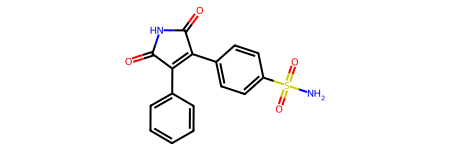

In [26]:
m0 = df.mol.values[0]
m0

First, we'll convert the molecule to fragments.

In [27]:
m0_frag_df = generate_fragments(m0)
m0_frag_df

,Scaffold,NumAtoms,NumRgroupgs
0,O=C1NC(=O)C(c2ccccc2)=C1c1ccccc1,19,1
1,NS(=O)(=O)c1ccc(C2=CC(=O)NC2=O)cc1,17,1
2,NS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)NC2=O)cc1,23,1


In [28]:
mols2grid.display(m0_frag_df,smiles_col="Scaffold")

MolGridWidget()

For second molecule

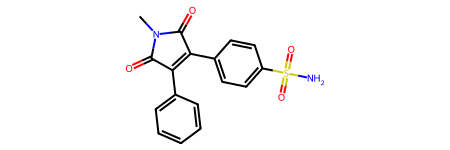

In [29]:
m1 = df.mol.values[1]
m1

In [30]:
m1_frag_df = generate_fragments(m1)
m1_frag_df

,Scaffold,NumAtoms,NumRgroupgs
0,NS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)NC2=O)cc1,23,1
1,NS(=O)(=O)c1ccc(C2=CC(=O)NC2=O)cc1,17,2
2,O=C1NC(=O)C(c2ccccc2)=C1c1ccccc1,19,2
3,CN1C(=O)C=C(c2ccc(S(N)(=O)=O)cc2)C1=O,18,1
4,CN1C(=O)C(c2ccccc2)=C(c2ccccc2)C1=O,20,1
5,CN1C(=O)C(c2ccccc2)=C(c2ccc(S(N)(=O)=O)cc2)C1=O,24,1


In [31]:
mols2grid.display(m1_frag_df,smiles_col="Scaffold")

MolGridWidget()

Let's combine the fragments from m0 and m1 into one dataframe.

In [32]:
m0m1_frag_df = pd.concat([m0_frag_df,m1_frag_df])

We can then use Pandas groupby to record the frequency of occurrence of each fragment.

In [33]:
scaffold_list = []
for k,v in m0m1_frag_df.groupby("Scaffold"):
    scaffold_list.append([k,len(v),v.NumAtoms.values[0]])
scaffold_df = pd.DataFrame(scaffold_list,columns=["Scaffold","Count","NumAtoms"])

In [34]:
scaffold_df.sort_values(["Count","NumAtoms"],ascending=[False,False],inplace=True)

The table below records the frequency of occurrence of each fragment.

In [35]:
mols2grid.display(scaffold_df,smiles_col="Scaffold",subset=["img","Count","NumAtoms"])

MolGridWidget()

We can use the function find_scaffolds to find scaffolds in the set of four molecules above.

In [36]:
mol_df, scaf_df = find_scaffolds(df)
mols2grid.display(scaf_df,smiles_col="Scaffold",subset=["img","Count","NumAtoms"])

  0%|          | 0/4 [00:00<?, ?it/s]

MolGridWidget()

In [20]:
scaf_df

,Scaffold,Count,NumAtoms
10,NS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)NC2=O)cc1,4,23
13,O=C1NC(=O)C(c2ccccc2)=C1c1ccccc1,4,19
11,NS(=O)(=O)c1ccc(C2=CC(=O)NC2=O)cc1,4,17
6,COc1ccc(C2=C(c3ccc(S(N)(=O)=O)cc3)C(=O)NC2=O)cc1,2,25
2,CN1C(=O)C(c2ccccc2)=C(c2ccc(S(N)(=O)=O)cc2)C1=O,2,24
9,NS(=O)(=O)c1ccc(C2=C(c3ccc(O)cc3)C(=O)NC2=O)cc1,2,24
8,COc1ccc(C2=C(c3ccccc3)C(=O)NC2=O)cc1,2,21
3,CN1C(=O)C(c2ccccc2)=C(c2ccccc2)C1=O,2,20
12,O=C1NC(=O)C(c2ccc(O)cc2)=C1c1ccccc1,2,20
4,CN1C(=O)C=C(c2ccc(S(N)(=O)=O)cc2)C1=O,2,18


In [37]:
mol_df

,Scaffold,NumAtoms,NumRgroupgs,Name,SMILES
0,O=C1NC(=O)C(c2ccccc2)=C1c1ccccc1,19,1,mol_001,NS(=O)(=O)C1=CC=C(C=C1)C1=C(C(=O)NC1=O)C1=CC=C...
1,NS(=O)(=O)c1ccc(C2=CC(=O)NC2=O)cc1,17,1,mol_001,NS(=O)(=O)C1=CC=C(C=C1)C1=C(C(=O)NC1=O)C1=CC=C...
2,NS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)NC2=O)cc1,23,1,mol_001,NS(=O)(=O)C1=CC=C(C=C1)C1=C(C(=O)NC1=O)C1=CC=C...
0,NS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)NC2=O)cc1,23,1,mol_002,CN1C(=O)C(=C(C1=O)C1=CC=C(C=C1)S(N)(=O)=O)C1=C...
1,NS(=O)(=O)c1ccc(C2=CC(=O)NC2=O)cc1,17,2,mol_002,CN1C(=O)C(=C(C1=O)C1=CC=C(C=C1)S(N)(=O)=O)C1=C...
2,O=C1NC(=O)C(c2ccccc2)=C1c1ccccc1,19,2,mol_002,CN1C(=O)C(=C(C1=O)C1=CC=C(C=C1)S(N)(=O)=O)C1=C...
3,CN1C(=O)C=C(c2ccc(S(N)(=O)=O)cc2)C1=O,18,1,mol_002,CN1C(=O)C(=C(C1=O)C1=CC=C(C=C1)S(N)(=O)=O)C1=C...
4,CN1C(=O)C(c2ccccc2)=C(c2ccccc2)C1=O,20,1,mol_002,CN1C(=O)C(=C(C1=O)C1=CC=C(C=C1)S(N)(=O)=O)C1=C...
5,CN1C(=O)C(c2ccccc2)=C(c2ccc(S(N)(=O)=O)cc2)C1=O,24,1,mol_002,CN1C(=O)C(=C(C1=O)C1=CC=C(C=C1)S(N)(=O)=O)C1=C...
0,CN1C(=O)C(c2ccc(O)cc2)=C(c2ccc(S(N)(=O)=O)cc2)...,25,1,mol_003,COC1=CC=C(C=C1)C1=C(C(=O)N(C)C1=O)C1=CC=C(C=C1...


The scaffolds above are sorted by frequency. We can look at the molecules containing the most frequently occurring scaffold by selecting the first scaffold in scaffold_df.

In [38]:
scaffold_0 = scaffold_df.Scaffold.values[0]
scaffold_0

'NS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)NC2=O)cc1'

In [43]:
infile_url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/CHEMBL208.smi"
chembl208_df = pd.read_csv(infile_url,names=["SMILES","Name","pIC50"])
chembl208_df.head()

,SMILES,Name,pIC50
0,O=c1[nH]c2ccc(-c3cccc(Cl)c3)cc2s1,CHEMBL94053,6.90
1,O=c1[nH]c2ccc(-c3cccc([N+](=O)[O-])c3)cc2n1Cc1...,CHEMBL327409,6.15
2,CC1=CC(C)(C)Nc2ccc(-c3cccc([N+](=O)[O-])c3)cc21,CHEMBL93027,7.70
3,CC(C)n1c(=O)[nH]c2ccc(-c3cccc(Cl)c3)cc21,CHEMBL329631,6.28
4,CC(C)n1c(=O)[nH]c2ccc(-c3cccc([N+](=O)[O-])c3)...,CHEMBL327444,6.28


In [44]:
chembl208_df['mol'] = chembl208_df.SMILES.apply(Chem.MolFromSmiles)

In [45]:
mol_df, scaffold_df = find_scaffolds(chembl208_df)

  0%|          | 0/513 [00:00<?, ?it/s]

In [46]:
scaffold_df

,Scaffold,Count,NumAtoms
5012,CC1=CC(C)(C)Nc2ccc3c(c21)COc1ccccc1-3,108,21
4312,CC1(C)C=Cc2c(ccc3c2COc2ccccc2-3)N1,93,20
5396,CC1=CC(C)Nc2ccc3c(c21)COc1ccccc1-3,92,20
2555,C=C1Oc2ccccc2-c2ccc3c(c21)C(C)=CC(C)(C)N3,64,22
2556,C=C1Oc2ccccc2-c2ccc3c(c21)C(C)=CC(C)N3,50,21
...,...,...,...
3933,CC(C)n1c(=O)[nH]c2ccccc21,1,13
11729,O=[SH](=O)Nc1ccc2cc[nH]c2c1,1,13
7372,CCn1c(=O)[nH]c2ccccc21,1,12
11001,Cn1c(=O)[nH]c2ccccc21,1,11


In [47]:
mols2grid.display(scaffold_df.head(10),smiles_col="Scaffold",subset=["img","Count"])

MolGridWidget()

In [48]:
scaffold_0 = scaffold_df.Scaffold.values[0]

The function get_molecules_with_scaffold will return all the molecules containing the specified scaffold. This function returns two values.

* A list of scaffolds with R-group substitution points labeled
* A dataframe with molecules containing that scaffold

In [49]:
scaffold_smiles_list, chembl208_mol_df = get_molecules_with_scaffold(scaffold_0, mol_df, chembl208_df)

Let's look at the scaffold with R-group labels

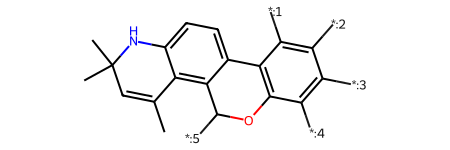

In [50]:
scaffold_mol = Chem.MolFromSmiles(scaffold_smiles_list[0])
scaffold_mol

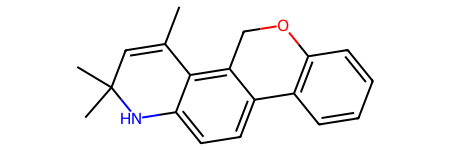

In [51]:
clean_scaffold_mol, _ = cleanup_fragment(scaffold_mol)
Compute2DCoords(clean_scaffold_mol)
clean_scaffold_mol

With this scaffold in hand, we can generate aligned structures for the molecules.

In [52]:
chembl208_mol_df['mol'] = chembl208_mol_df.SMILES.apply(Chem.MolFromSmiles)

In [53]:
for mol in chembl208_mol_df.mol:
    AllChem.GenerateDepictionMatching2DStructure(mol,clean_scaffold_mol)

In [54]:
mols2grid.display(chembl208_mol_df.sort_values("pIC50",ascending=False),
                  mol_col='mol',use_coords=True, prerender=True, substruct_highlight=False,
                  transform={"pIC50" : lambda x: f"{x:.1f}"},
                  subset=["img","Name","pIC50"])

MolGridWidget()